In [1]:
### This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random
import matplotlib.pyplot as plt
import math
import copy
import pickle # reading pkl file
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import SGD, Rprop, ASGD, Adam, RMSprop, Adagrad, AdamW

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
from IPython.display import clear_output

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.cuda.is_available()

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

True

In [2]:
# Calculate the distance between two points
def calc_distance(a, b):
    return math.sqrt((a[0] - b[0]) ** 2 + (a[1] - b[1]) ** 2)

# Calculate the verticle distance between one point and a line
def calc_vertical(line, point):
    A = np.array([[line[0],line[1]],[line[1],-line[0]]])
    Y = np.array([[point[0]],[point[1]]])
    solve = np.linalg.solve(A, Y)
    return calc_distance([0,0], [line[0] * solve[1], -line[1] * solve[1]])

# Use for append value (maybe need modify value before append)
def input_value(array, value):
    array.append(value)

# Use to reverse the modification of above function
def output_value(value):
    return value

# Calculate the angle between two lines
def angle(vector_1, vector_2):
    if vector_1[0] == vector_2[0] and vector_1[1] == vector_2[1]:
        return 0
    unit_vector_1 = vector_1 / np.linalg.norm(vector_1)
    unit_vector_2 = vector_2 / np.linalg.norm(vector_2)
    dot_product = np.dot(unit_vector_1, unit_vector_2)
    return np.arccos(dot_product) / math.pi * 180

# Determine if a point is left or right of a line
def left_or_right(vector, point):
    if vector[0] * point[1] - vector[1] * point[0] > 0:
        return 1
    elif vector[0] * point[1] - vector[1] * point[0] < 0:
        return -1
    else:
        return 0

# Determine which position is a point to (0,0).
# Front represent the front of the car, pos is another car,
# If the other car is ahead of us, return 0,
# Front-right, return 1, right, return 2, etc, until front-left return 7
def classify_area(front, pos):
    if angle(front, pos) < 25 and calc_vertical(front, pos) < 3:
        return 0
    elif angle(front, pos) < 90:
        if left_or_right(front, pos) == 1:
            return 5
        else:
            return 1
    elif angle(front, pos) < 155:
        if left_or_right(front, pos) == 1:
            return 4
        else:
            return 2
    return 3

# Sort a dictionary according to its values
def sort_dict(x):
    return dict(sorted(x.items(), key=lambda item: item[1]))

# Rotate a point around center at some angle
def rotate(point, angle):
    px = point[0]
    py = point[1]

    qx = math.cos(math.radians(angle)) * px - math.sin(math.radians(angle)) * py
    qy = math.sin(math.radians(angle)) * px + math.cos(math.radians(angle)) * py
    return [qx, qy]

# Get the angle difference between [1,0] and a point
def getAngle(front):
    if left_or_right(front, [1,0]) >= 0:
        return angle(front, [1,0])
    else:
        return -angle(front, [1,0])
    
# Make an array of values to rotate around some degree
def re_do_arr(arr, angle):
    for i in range(int(len(arr)/2)):
        arr[i*2:i*2+2] = rotate(arr[i*2:i*2+2], angle)
    return arr

def check_exist(arr, arr_arr):
    outer_index = 0
    for i in arr_arr:
        index = 0
        same = True
        for j in i:
            if j != arr[index]:
                same = False
                break
            index += 1
        if same:
            return True, outer_index
        outer_index += 1
    return False, -1

In [3]:
# Create input array
def get_input(data, target_index = -1):
    # Get the index of the target car
    if target_index == -1:
        index = 0
        target_index = 0
        for track_id in data['track_id']:
            if track_id[0] == data['agent_id']:
                target_index = index
            index = index + 1
    
    # Record start/end position/velocity of the target car
    end_pox_x = data['p_in'][target_index][18][0]
    end_pox_y = data['p_in'][target_index][18][1]
    
    # Get the road and the road norm of the target car at the end of the 2 sec
    index = 0
    min_distance = None
    min_index = 0
    for lane in data['lane']:
        if min_distance == None or min_distance > calc_distance([end_pox_x, end_pox_y], lane):
            min_distance = calc_distance([end_pox_x, end_pox_y], lane)
            min_index = index
        index = index + 1
    front = data['lane_norm'][min_index][0:2]
    road = data['lane'][min_index][0:2]
    
    sum_vel = [0, 0]
    for j in range(10, 19):
        sum_vel[0] += data['v_in'][target_index][j][0]
        sum_vel[1] += data['v_in'][target_index][j][1]
    turn_angle = getAngle(sum_vel)

    # Get the cars in eight directions of the target car, as well as the car in the opposite direction but closest to the target car
    index = 0
    six_dir = [None, None, None, None, None, None]
    six_dist = [None, None, None, None, None, None]
    for p_in in data['p_in']:
        if index != target_index and data['car_mask'][index] == 1:
            sum_vel_index = [0,0]
            for j in range(10, 19):
                sum_vel_index[0] += data['v_in'][index][j][0]
                sum_vel_index[1] += data['v_in'][index][j][1]
            if angle(sum_vel, sum_vel_index) < 30:
                position = [data['p_in'][index][18][0] - end_pox_x, data['p_in'][index][18][1] - end_pox_y]
                direction = classify_area(sum_vel, position)
                if direction != -1 and (six_dir[direction] == None or calc_distance([0,0], position) < six_dist[direction]):
                    six_dir[direction] = index
                    six_dist[direction] = calc_distance([0,0], position)
        index = index + 1
        
    train_array = []

    # Input data 0-3: the opposition and direction of the road that the target car is on
    input_value(train_array, float(front[0]))
    input_value(train_array, float(front[1]))
    input_value(train_array, float(road[0] - end_pox_x))
    input_value(train_array, float(road[1] - end_pox_y))
    
    # Input data 4-79: the position and velocity of the target car in 2 sec
    for j in range(19):
        input_value(train_array, data['p_in'][target_index][j][0] - end_pox_x)
        input_value(train_array, data['p_in'][target_index][j][1] - end_pox_y)
        input_value(train_array, data['v_in'][target_index][j][0])
        input_value(train_array, data['v_in'][target_index][j][1])
            
    # Input Data 79-103: Do the same for cars in eight direction
    for one_dir in six_dir:
        if one_dir != None:
            input_value(train_array, data['p_in'][one_dir][18][0] - end_pox_x)
            input_value(train_array, data['p_in'][one_dir][18][1] - end_pox_y)
            input_value(train_array, data['v_in'][one_dir][18][0])
            input_value(train_array, data['v_in'][one_dir][18][1])
        else:
            input_value(train_array, 0)
            input_value(train_array, 0)
            input_value(train_array, 0)
            input_value(train_array, 0)
    re_do_arr(train_array, turn_angle)
    return train_array

In [4]:
# Create output array
def get_output_p(data):
    # Get the index of the target car
    index = 0
    target_index = 0
    for track_id in data['track_id']:
        if track_id[0] == data['agent_id']:
            target_index = index
        index = index + 1
        
    end_pox_x = data['p_in'][target_index][18][0]
    end_pox_y = data['p_in'][target_index][18][1]
    # y_train is the velocity of next 3 sec
    
    # Get the road and the road norm of the target car at the end of the 2 sec
    index = 0
    min_distance = None
    min_index = 0
    for lane in data['lane']:
        if min_distance == None or min_distance > calc_distance([end_pox_x, end_pox_y], lane):
            min_distance = calc_distance([end_pox_x, end_pox_y], lane)
            min_index = index
        index = index + 1
    front = data['lane_norm'][min_index][0:2]
    road = data['lane'][min_index][0:2]
    
    sum_vel = [0, 0]
    for j in range(10, 19):
        sum_vel[0] += data['v_in'][target_index][j][0]
        sum_vel[1] += data['v_in'][target_index][j][1]
    turn_angle = getAngle(sum_vel)
    
    output_array = []
    for j in range(30):
        input_value(output_array, data['p_out'][target_index][j][0] - end_pox_x)
        input_value(output_array, data['p_out'][target_index][j][1] - end_pox_y) 
    re_do_arr(output_array, turn_angle)
    return output_array

In [5]:
# This is almost the same as before, except we put 60 more values into x_train and output is p_out
x_train = []
y_train = []

TOTAL_DATA = 180000

address = 'cse151b-spring/new_train/new_train/'

for i in range(0, TOTAL_DATA):
    clear_output(wait=True)
    print(i)
    filepath = address + str(i) + '.pkl'
    file = open(filepath, 'rb')
    data = pickle.load(file)
    file.close()
    
    x_train.append(get_input(data))
    
    y_train.append(get_output_p(data))
    
# The same as above
x_train = np.array(x_train)
y_train = np.array(y_train)
tensor_x = torch.Tensor(x_train).to(device) # transform to torch tensor
tensor_y = torch.Tensor(y_train).to(device)

179999


In [6]:
# Validate the model
x_test = []
y_test = []

address = 'cse151b-spring/new_train/new_train/'

for i in range(TOTAL_DATA, 205942):
    clear_output(wait=True)
    print(i)
    filepath = address + str(i) + '.pkl'
    file = open(filepath, 'rb')
    data = pickle.load(file)
    file.close()
        
    x_test.append(get_input(data))
    
    y_test.append(get_output_p(data))

x_test = np.array(x_test)
y_test = np.array(y_test)
test_tensor_x = torch.Tensor(x_test).to(device) # transform to torch tensor
test_tensor_y = torch.Tensor(y_test).to(device)
test_dataset = TensorDataset(test_tensor_x,test_tensor_y) # create your datset
test_dataloader = DataLoader(test_dataset, batch_size = 5000) # create your dataloader

205941


In [7]:
# Train function
def train(model, x, y, optimizer, criterion):
    optimizer.zero_grad()
    output = model(x)
    loss =criterion(output,y)
    loss.backward()
    optimizer.step()
    return loss, output

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2152, 2048)
        self.fc2 = nn.Linear(2152, 2048)
        self.fc3 = nn.Linear(2152, 2048)
        self.fc4 = nn.Linear(2152, 60)
        self.act1 = nn.ReLU()
        self.act2 = nn.Sigmoid()
        self.lay1 = nn.LayerNorm(2048)
        
    def forward(self, x):
        y = torch.zeros(len(x), 2048, device=device)
        for i in range(12):
            if i != 0:
                y = self.lay1(y)
            if i % 3 == 0:
                y = self.fc1(torch.cat((x, y), 1))
                y = self.act1(y)
            elif i % 3 == 1:
                y = self.fc2(torch.cat((x, y), 1))
                y = self.act1(y)
            else:
                y = self.fc3(torch.cat((x, y), 1))
                y = self.act2(y)
        y = self.lay1(y)
        x = self.fc4(torch.cat((x, y), 1))
        return x
    

def getTestError(model, criterion):
    score = 0
    total = 0
    loss = 0
    for bidx, batch in enumerate(test_dataloader):
        x_test, y_test = batch[0], batch[1]
        output = model(x_test)
        loss=criterion(output,y_test)
    score = math.sqrt(loss)
    return score

In [9]:
BATCH_SIZE = 250
EPOCH_LENGTH = 50

# Train the data
my_dataset = TensorDataset(tensor_x,tensor_y) # create your datset
my_dataloader = DataLoader(my_dataset, batch_size = BATCH_SIZE, num_workers=0) # create your dataloader

model = None

criterion = nn.MSELoss().to(device)
model = Net().to(device)
optm = Adam(model.parameters(), lr=0.0005)

last_score = 0
last_loss = 0
test_score = 0

train_loss = []
test_loss = []

epoch_models = []

for epoch in range(EPOCH_LENGTH):
    score = 0
    total = 0
    loss = 0
    batch_num = 0
    my_dataloader = DataLoader(my_dataset, batch_size = BATCH_SIZE, shuffle=True, num_workers=0)  # create your dataloader
    for x_train, y_train in my_dataloader:
        batch_num += 1
        clear_output(wait=True)
        print('Epoch : {}'.format(epoch) + '\nBatch : {}'.format(batch_num) + 
              '\nScore : {}'.format(math.sqrt(score / (total+1))) + 
              '\nLast Train Error : {}'.format(last_score) + '\nLast Test Error : {}'.format(test_score))
        loss, _ = train(model, x_train,y_train, optm, criterion)
        score += loss
        total += 1
        
    last_score = math.sqrt(score / total)
    train_loss.append(last_score)
    test_score = getTestError(model, criterion)
    test_loss.append(test_score)
    epoch_models.append(copy.deepcopy(model))

Epoch : 32
Batch : 295
Score : 1.9399138764800334
Last Train Error : 1.9677208526627719
Last Test Error : 2.3185124977405134


KeyboardInterrupt: 

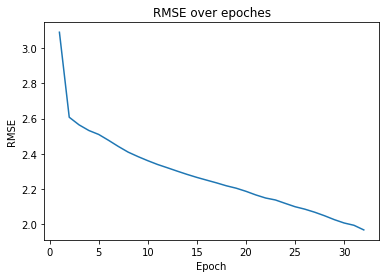

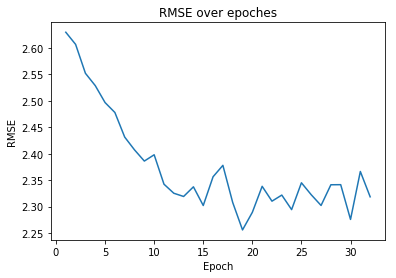

Min test error model: 18
Min train error loss: 2.2047250767458473
Min test error loss: 2.255898902183464


In [14]:
x_axis = []
for i in range(len(train_loss)):
    x_axis.append(i+1)

plt.plot(x_axis, train_loss)
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('RMSE over epoches')
plt.show()

min_loss_index = 0
x_axis = []
for i in range(len(test_loss)):
    x_axis.append(i+1)
    if test_loss[i] < test_loss[min_loss_index]:
        min_loss_index = i

plt.plot(x_axis, test_loss)
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('RMSE over epoches')
plt.show()
print("Min test error model: " + str(min_loss_index))
print("Min train error loss: " + str(train_loss[min_loss_index]))
print("Min test error loss: " + str(test_loss[min_loss_index]))

In [11]:
# The actural test and produce a df to submit
column_names = ['ID']

for i in range(1,61):
    column_names.append('v' + str(i))

df_output = pd.DataFrame(columns = column_names)

for root, dirs, files in os.walk( 'cse151b-spring/new_val_in/new_val_in/'):
    for name in files:
        filepath = os.path.join(root, name)
        file = open(filepath, 'rb')
        data = pickle.load(file)
        file.close()
        
         # Get the index of the target car
        index = 0
        target_index = 0
        for track_id in data['track_id']:
            if track_id[0] == data['agent_id']:
                target_index = index
            index = index + 1
        
        end_pox_x = data['p_in'][target_index][18][0]
        end_pox_y = data['p_in'][target_index][18][1]
        # y_train is the velocity of next 3 sec
    
        # Get the road and the road norm of the target car at the end of the 2 sec
        index = 0
        min_distance = None
        min_index = 0
        for lane in data['lane']:
            if min_distance == None or min_distance > calc_distance([end_pox_x, end_pox_y], lane):
                min_distance = calc_distance([end_pox_x, end_pox_y], lane)
                min_index = index
            index = index + 1
        front = data['lane_norm'][min_index][0:2]
        road = data['lane'][min_index][0:2]
    
        sum_vel = [0, 0]
        for j in range(10, 19):
            sum_vel[0] += data['v_in'][target_index][j][0]
            sum_vel[1] += data['v_in'][target_index][j][1]
        turn_angle = getAngle(sum_vel)
            
        test_array = get_input(data)
        test_array = torch.Tensor([test_array]).to(device)
        
        outcome = epoch_models[min_loss_index](test_array).tolist()[0]
        
        for j in range(30):
            outcome[j*2:j*2+2] = rotate(outcome[j*2:j*2+2], -turn_angle)
            outcome[j*2] = output_value(outcome[j*2]) + end_pox_x
            outcome[j*2+1] = output_value(outcome[j*2+1]) + end_pox_y
            if math.isnan(outcome[j*2]):
                outcome[j*2] = end_pox_x
                outcome[j*2+1] = end_pox_y
        output_list = [int(data["scene_idx"])]
        output_list.extend(outcome)
        
        df_length = len(df_output)
        df_output.loc[df_length] = output_list
        
        clear_output(wait=True)
        print(df_length)

3199


In [12]:
df_output = df_output.astype({'ID': int})

In [13]:
df_output.to_csv('cse151b-spring/output.csv', header=column_names, index=False)